## Load Sentinel-1 data 



In [1]:
import os
import xarray as xr
import rioxarray
import rasterio
import dask.array as da
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import folium
import matplotlib.patches as patches
from datetime import datetime
import pandas as pd


Load Metadata to get some information on the data. We want to get the scale_factor of the data.

In [3]:
data_path = Path('~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler').expanduser() # SAT-1 data is inside the saocom_gamma folder but this could change
tif_files = glob(f"{data_path}/*.tif")

for tif_path in tif_files:
    print(f"Metadata for file: {os.path.basename(tif_path)}")
    with rasterio.open(tif_path) as src:
      tags = src.tags()
      print(src.meta)
      print(f"Tags: {tags}")
      print(f"Scalefactor: {tags.get('scale_factor')}\n")
      break
    

Metadata for file: D20230829_165123--_GMR------_S1AIWGRDH1VVA_146_A0105_EU010M_E052N015T1.tif
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 10000, 'height': 10000, 'count': 1, 'crs': CRS.from_epsg(27704), 'transform': Affine(10.0, 0.0, 5200000.0,
       0.0, -10.0, 1600000.0)}
Tags: {'abs_orbit_number': '050093', 'band_1': 'Gamma0_VV', 'border_noise_removed': 'True', 'creator': 'TUWGEO', 'distanceuom': 'm', 'distancevalue': '10', 'equi7_tile': 'EU010M_E052N015T1', 'ext_dem': '/eodc/private/tuwgeo/users/acube/data/input/acube_dem_eh.tif', 'grid': 'Equi7 Grid', 'gtc_applied': 'True', 'log_file': 'tasklist_2_A01_gmr_jobfile_A0105_log_20231201_073256.xml', 'orbit_aux_file': 'POE', 'parent_data_file': 'S1A_IW_GRDH_1SDV_20230829T165123_20230829T165148_050093_060726_855E.zip', 'polarisation': 'VV', 'precise_orbit_applied': 'True', 'processing_date': '2023-12-01 07:32:57', 'processing_software': 'SGRT', 'processing_software_version': 'A0105-2.4.9.post.dev6.pre', 'rel_orbit_

As we can see frome here the data was captured between ... .

Now we can load the data and and apply preprocessing. From the Metaddata we could extract a scalingfactor of 100 which we now need to apply.

We get a xarray.DataSet and convert it to an xarray.DataArray because we only have one variable, the VV backscatter.

In [5]:
def _preprocess(x):  
    scale_factor = pd.to_numeric(
        rasterio.open(x.encoding["source"]).tags().get('scale_factor')
    )

    time_value = pd.to_datetime(
        rasterio.open(x.encoding["source"]).tags().get('time_begin')
    )

    x = x / scale_factor

    x = x.assign_coords(time=time_value).expand_dims("time")

    return x.squeeze("band").drop_vars("band")

ds = xr.open_mfdataset(
    '~/shared/datasets/rs/datapool/mrs/saocom_gamma/S1gammaNeusiedler/*.tif',
    engine="rasterio",
    combine='nested',
    concat_dim="time",
    preprocess=_preprocess
)

ds = ds[list(ds.data_vars.keys())[0]] 
ds = ds.chunk({'x': 1000, 'y': 1000})
ds

<xarray.DataArray 'band_data' (time: 8, y: 10000, x: 10000)> Size: 6GB
dask.array<rechunk-merge, shape=(8, 10000, 10000), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 80kB 5.2e+06 5.2e+06 5.2e+06 ... 5.3e+06 5.3e+06
  * y            (y) float64 80kB 1.6e+06 1.6e+06 1.6e+06 ... 1.5e+06 1.5e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...

We transform our Data to the EPSG:4326 coordinate system which uses Latitude and Longitude values.

In [6]:
ds_WGS84 = ds.rio.reproject("EPSG:4326")
ds_WGS84

<xarray.DataArray 'band_data' (time: 8, y: 8415, x: 12405)> Size: 7GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 99kB 15.46 15.46 15.46 15.46 ... 16.91 16.91 16.91
  * y            (y) float64 67kB 48.07 48.07 48.07 48.07 ... 47.09 47.09 47.09
  * time         (time) datetime64[ns] 64B 2023-08-05T16:51:22 ... 2023-10-28...
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  nan

In [7]:
ds_WGS84_downsampled = ds_WGS84.isel().coarsen(x=10, y=10, boundary='pad').mean()


KeyboardInterrupt



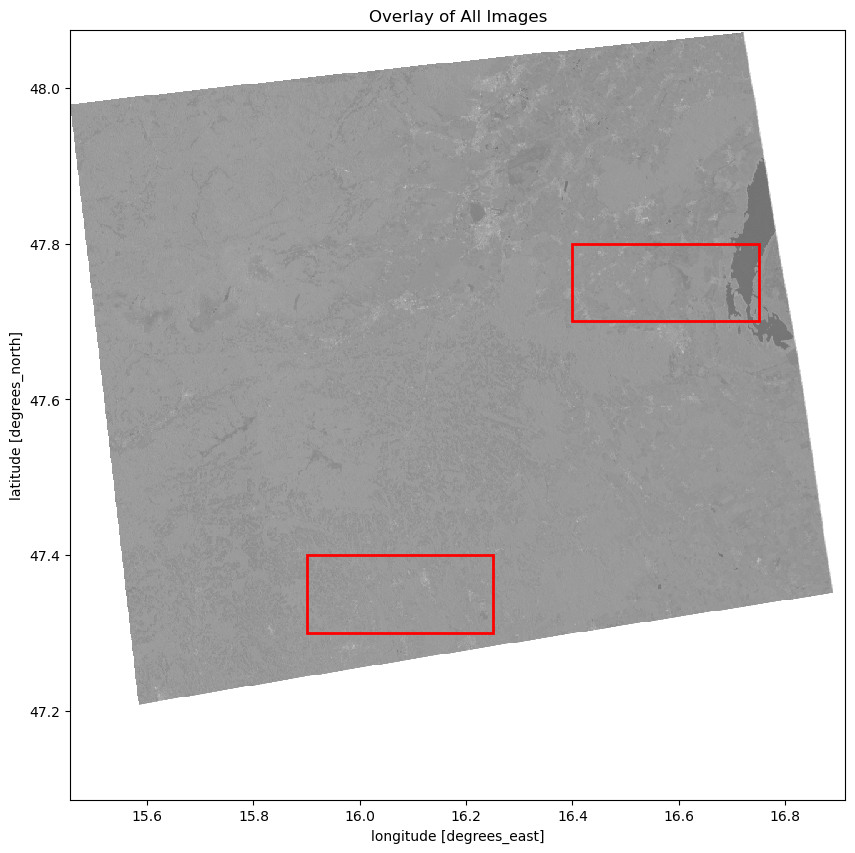

In [35]:
data_vars = list(ds_WGS84.data_vars)

areas = [
    {'lat_min': 47.7, 'lat_max': 47.8, 'lon_min': 16.4, 'lon_max': 16.75},
    {'lat_min': 47.3, 'lat_max': 47.4, 'lon_min': 15.9, 'lon_max': 16.25}
]


fig, ax = plt.subplots(figsize=(10, 10))

for var in data_vars:
    img = ds_WGS84_downsampled[var]
    img.plot(ax=ax, add_colorbar=False, cmap='gray', alpha=0.1)  # Adjust alpha for transparency

for area in areas:   
    rect = patches.Rectangle(
        (area['lon_min'], area['lat_min']), 
        area['lon_max'] - area['lon_min'], 
        area['lat_max'] - area['lat_min'],
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

ax.set_title('Overlay of All Images')

plt.show()

# Code not curently used

We want to use the Koordinatesystem EPSG:4326 (WGS 84) which uses Latitude and Longitude values. For the transformation chunks are needed to avoid the RAM to overflow. This can take a few minutes.

In [ ]:
ds.chunk(chunks={'x': 1000, 'y': 1000})

ds_WGS84 = ds.rio.reproject("EPSG:4326")
ds_WGS84

## Plotting in the EPSG:27704
In the EPSG:27704 coordinate system (plotting is quite slow):

In [ ]:
ds_downsampled = ds.isel().coarsen(x=10, y=10, boundary='pad').mean()

In [ ]:
data_vars = list(ds.data_vars)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot each variable (image) in the dataset
for var in data_vars:
    img = ds_downsampled[var]
    img.plot(ax=ax, add_colorbar=False, cmap='gray', alpha=0.03)  # Adjust alpha for transparency

plt.show()

## Get the overlapping area

In [ ]:
data_vars = list(ds_WGS84.data_vars)

ds_overlapping = ds_WGS84[data_vars[0]]  # Start with the first variable

for var in data_vars[1:]:
    next_image = ds_WGS84[var]
    ds_overlapping = ds_overlapping.rio.clip_box(*next_image.rio.bounds())

To reduce the runtime we downsample the data to make the plotting faster.

In [ ]:
ds_downsampled = ds_WGS84.isel().coarsen(x=10, y=10, boundary='pad').mean()
ds_overlapping_downsampled = ds_overlapping.isel().coarsen(x=10, y=10, boundary='pad').mean()

In [ ]:
ds_downsampled[data_vars[0]].plot()

In [ ]:
ds_overlapping_downsampled.plot()

KeyboardInterrupt: 

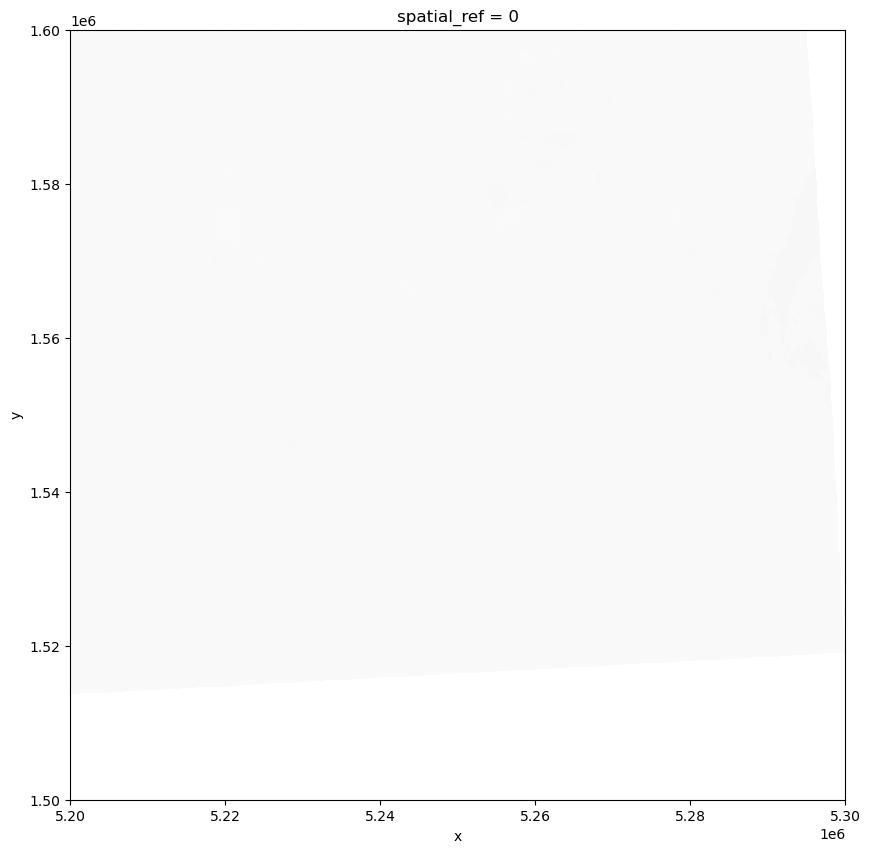

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each variable (image) in the dataset
for var in data_vars:
    img = ds_downsampled[var]
    img.plot(ax=ax, add_colorbar=False, cmap='gray', alpha=0.03)  # Adjust alpha for transparency

# Highlight the overlapping area with a colored box
minx, miny, maxx, maxy = ds_overlapping_downsampled.rio.bounds()

# Add a colored box for the overlapping area
rect = plt.Rectangle((minx, miny), maxx - minx, maxy - miny, fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

# Set labels and titles
ax.set_title("Overlapping Area of Satellite Images")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


In [ ]:
ds_downsampled = ds_WGS84.isel().coarsen(x=100, y=100, boundary='pad').mean()

ds_downsampled.plot.scatter()

#plt.figure(figsize=(12, 8))
#downsampled_data.plot(cmap='viridis')
#plt.title('Resampled Data Slice at Time = 0')
#plt.show()

## Select VV and VH

## Plotting a histogram